# Demo of SCOD with a simple 2D dataset

In [1]:
%load_ext autoreload
%autoreload 2

import scod
import torch
import numpy as np
from tqdm import trange

import seaborn as sns
from matplotlib import pyplot as plt

First, define the dataset

In [2]:
class TwoDDataset(torch.utils.data.Dataset):
    def __init__(self, N=100, fn=(lambda x: np.sin(2*x) ), split='train') -> None:
        super().__init__()
        if split == 'train':
            np.random.seed(1001)
        elif split == 'val':
            np.random.seed(2001)
        else:
            np.random.seed(3001)
        x1 = np.concatenate([-1.5 + np.random.rand(N//2), 0.5 + np.random.rand(N - N//2)])
        x2 = -1 + 2*np.random.rand(N)
        noise = 0.05*np.random.randn(N)
        x = np.stack([x1,x2],axis=-1)
        y = fn(x.sum(-1)) + noise
        self.X = torch.from_numpy(x).float()
        self.Y = torch.from_numpy(y).float() 

        self.N = N

    def __len__(self):
        return self.N
    
    def __getitem__(self, idx):
        return (self.X[idx,:], self.Y[idx,None])

class UniformDataset(torch.utils.data.Dataset):
    def __init__(self, N=500) -> None:
        super().__init__()

        x = -3 + 6*np.random.rand(N*2).reshape([N,2])
        y = x[:,0]
        self.X = torch.from_numpy(x).float()
        self.Y = torch.from_numpy(y).float() 

        self.N = N

    def __len__(self):
        return self.N
    
    def __getitem__(self, idx):
        return (self.X[idx,:], self.Y[idx,None])


Next, we create a model (simple MLP), and train it to fit this data

In [3]:
# DNN mapping 2d input to 1d distribution parameter
relu_model = torch.nn.Sequential(
    torch.nn.Linear(2, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1)
)

relu_dist_layer = scod.distributions.NormalMeanParamLayer()
joint_relu_model = torch.nn.Sequential(relu_model, relu_dist_layer)

In [4]:
tanh_model = torch.nn.Sequential(
    torch.nn.Linear(2, 64),
    torch.nn.Tanh(),
    torch.nn.Linear(64, 64),
    torch.nn.Tanh(),
    torch.nn.Linear(64, 64),
    torch.nn.Tanh(),
    torch.nn.Linear(64, 1)
)
tanh_dist_layer = scod.distributions.NormalMeanParamLayer()
joint_tanh_model = torch.nn.Sequential(tanh_model, tanh_dist_layer)

### train a base DNN model

mean_loss=-0.645324: 100%|██████████| 50/50 [00:00<00:00, 108.58it/s]


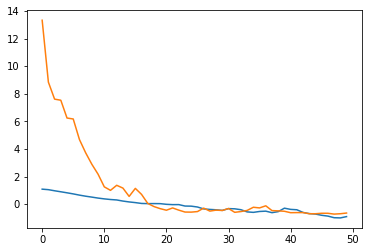

In [5]:
for model in [joint_relu_model, joint_tanh_model]:
    dataset = TwoDDataset()
    train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

    losses = []
    t = trange(50)

    for epoch in t:
        epoch_loss = 0.
        for (inputs, targets) in train_dataloader:
            optimizer.zero_grad()
            
            dist = model(inputs)
            loss = -dist.log_prob(targets)

            mean_loss = loss.mean()

            mean_loss.backward()

            epoch_loss += mean_loss
            
            optimizer.step()
            
        epoch_loss /= len(train_dataloader)
        
        t.set_description("mean_loss=%02f"%epoch_loss.item())
        losses.append(epoch_loss.item())

    plt.plot(losses)

Visualize the simple trained DNN

Text(0.5, 1.0, 'Tanh Model')

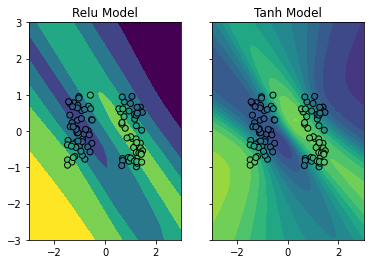

In [6]:
X1,X2 = np.meshgrid( np.linspace(-3.,3.,50), np.linspace(-3.,3.,50) )
X = np.stack([X1,X2], axis=-1)
xx_tensor = torch.from_numpy(X).view(-1,2).float()

yhat_relu = relu_model(xx_tensor)
yhat_relu = yhat_relu[:,0].detach().cpu().numpy()

yhat_tanh = tanh_model(xx_tensor)
yhat_tanh = yhat_tanh[:,0].detach().cpu().numpy()

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)

axes[0].contourf(X1,X2,yhat_relu.reshape(X1.shape), levels=10, vmin=-2., vmax=2.)
axes[0].scatter(dataset.X[:,0], dataset.X[:,1], c=dataset.Y, vmin=-2, vmax=2, edgecolors='k')
axes[0].set_title("Relu Model")

axes[1].contourf(X1,X2,yhat_tanh.reshape(X1.shape), levels=10, vmin=-2., vmax=2.)
axes[1].scatter(dataset.X[:,0], dataset.X[:,1], c=dataset.Y, vmin=-2, vmax=2, edgecolors='k')
axes[1].set_title("Tanh Model")

### Applying SCOD
Now, we apply SCOD to the network to add uncertainty estimation

In [8]:
tanh_unc_model = scod.SCOD(tanh_model, args={
    'num_eigs': 50,
    'num_samples': 304,
    'sketch_type': 'srft',
})

relu_unc_model = scod.SCOD(relu_model, args={
    'num_eigs': 50,
    'num_samples': 304,
    'sketch_type': 'srft',
})

Weight space dimension: 8.577e+03
Weight space dimension: 8.577e+03


### process training dataset to compute posterior uncertainty

In [9]:
tanh_unc_model.process_dataset(dataset, tanh_dist_layer)

relu_unc_model.process_dataset(dataset, relu_dist_layer)


computing basis
using T = 304


  0%|          | 0/100 [00:00<?, ?it/s]

computing basis
using T = 304


  0%|          | 0/100 [00:00<?, ?it/s]

### compare SCOD's predictions to the original trained model

In [13]:
settings = [
    {   
        'name': 'Tanh Activations',
        'model': tanh_unc_model,
        'dist_layer': tanh_dist_layer,
    },
    {   
        'name': 'ReLU Activations',
        'model': relu_unc_model,
        'dist_layer': relu_dist_layer,
    },
]

In [11]:
X1,X2 = np.meshgrid( np.linspace(-3.,3.,50), np.linspace(-3.,3.,50) )
X = np.stack([X1,X2], axis=-1)
xx_tensor = torch.from_numpy(X).view(-1,2).float()

In [14]:
results = []
for setting in settings:
    scod_model = setting['model']
    
    z_mean, z_var = scod_model(xx_tensor)
    marg_dist = setting['dist_layer'].marginalize_gaussian(z_mean, z_var)



    _, z_prior_var = scod_model(xx_tensor, use_prior=True)
    marg_prior_dist = setting['dist_layer'].marginalize_gaussian(z_mean, z_prior_var)

    z_mean_dataset, _ = scod_model(dataset.X)
    z_mean_dataset = z_mean_dataset[:,:1]
    sq_err = (dataset.Y - z_mean_dataset)**2

    result = {
        'name': setting['name'],
        'z_vars': z_var.detach().cpu().numpy().reshape(X1.shape),
        'total_var': marg_dist.variance.detach().cpu().numpy().reshape(X1.shape),
        'prior_z_vars': z_prior_var.detach().cpu().numpy().reshape(X1.shape),
        'total_prior_var': marg_prior_dist.variance.detach().cpu().numpy().reshape(X1.shape),
        'sq_err' : sq_err.detach().cpu().numpy()
    }
    results.append(result)

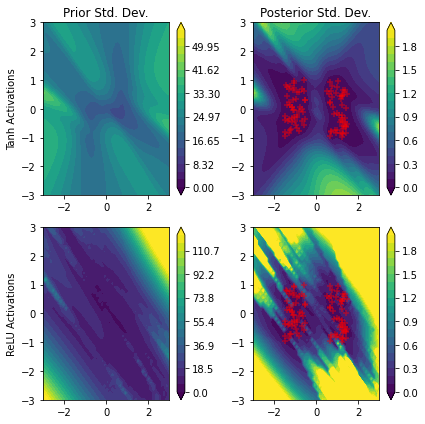

In [20]:
fig, axes = plt.subplots(len(results), 2, figsize=[6,6])
for i, result in enumerate(results):
    max_unc = max(np.round(np.quantile(result['total_prior_var'], 0.9) /0.9 )*1.5, 1.)
    levels = np.linspace(0., max_unc, 21)
    m = axes[i,0].contourf(X1,X2,result['total_prior_var'], vmin=0., vmax=max_unc, extend='both', levels=levels)
    plt.colorbar(m, ax=axes[i,0])
    m.set_clim([0, m.get_clim()[1]])
    
    levels = np.linspace(0., 2., 21)
    m = axes[i,1].contourf(X1,X2,result['total_var'], vmin=0., vmax=2., levels=levels, extend='both')
    plt.colorbar(m, ax=axes[i,1])
    m.set_clim([0, m.get_clim()[1]])
    axes[i,1].scatter(dataset.X[:,0], dataset.X[:,1], marker='+', vmin=-2, vmax=2, color='red', alpha=0.5)

    axes[i,0].set_ylabel(result['name'])

axes[0,0].set_title('Prior Std. Dev.')
axes[0,1].set_title('Posterior Std. Dev.')

plt.tight_layout()
plt.savefig("qualitative_2d.pdf")